## MMTHE01 - Masters Thesis

### E1. Thesis - Apply and Evaluate different XAI methods - Case Study with XGBoost Model
* Applying XAI on a Supervised Learning AI model (XGBoost with SMOTE)
* Applying Model Agnostic Perturbation-based local XAI methods: SHAP, LIME Anchors, Counterfactual

#### Importing the libraries

In [1]:
### import general libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import time
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import recall_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import LabelEncoder

In [2]:
# Check your current working directory
cwd = os.getcwd()

# Define your relative path
relative_path = r"6. Analysis"  # adjust this relative to cwd

# Build the full path
full_path = os.path.join(cwd, relative_path)

# Check if it exists before changing
if os.path.exists(full_path):
    os.chdir(full_path)
    print("Changed directory to:", full_path)
else:
    print("Folder does not exist:", full_path)

Changed directory to: C:\Users\eaber\Documents\11. Masters Thesis Final\6. Analysis


#### Importing the dataset

In [3]:
dataset = pd.read_csv('train_dataset_final_encoded.csv')

In [4]:
dataset.head()

isFraud  TransactionDT  TransactionAmt  card1   C3   C9  C12   C13  C14  \
0        0          86400            68.5  13926  0.0  1.0  0.0   1.0  1.0   
1        0          86401            29.0   2755  0.0  0.0  0.0   1.0  1.0   
2        0          86469            59.0   4663  0.0  1.0  0.0   1.0  1.0   
3        0          86499            50.0  18132  0.0  1.0  0.0  25.0  1.0   
4        0          86506            50.0   4497  0.0  0.0  0.0   1.0  1.0   

   TransactionID  ...  card4_discover  card4_mastercard  card4_visa  \
0        2987000  ...             1.0               0.0         0.0   
1        2987001  ...             0.0               1.0         0.0   
2        2987002  ...             0.0               0.0         1.0   
3        2987003  ...             0.0               1.0         0.0   
4        2987004  ...             0.0               1.0         0.0   

   card6_charge card  card6_credit  card6_debit  card6_debit or credit  M4_M0  \
0                0.0           1.0          0.0                    0.0    0.0   
1                0.0           1.0          0.0                    0.0    1.0   
2                0.0           0.0          1.0                    0.0    1.0   
3                0.0           0.0          1.0                    0.0    1.0   
4                0.0           1.0          0.0                    0.0    1.0   

   M4_M1  M4_M2  
0    0.0    1.0  
1    0.0    0.0  
2    0.0    0.0  
3    0.0    0.0  
4    0.0    0.0  

[5 rows x 201 columns]

In [5]:
dataset.shape

(590540, 201)

### 5.1 Split the data into Train-Test

#### 5.1.1 Separate the features and the label

In [6]:
dataset_final = dataset.drop('TransactionID', axis=1)

In [7]:
#X = dataset.iloc[:, 1:].values
#y = dataset.iloc[:,0].values

In [8]:
X = dataset_final.iloc[:, 1:]
y = dataset_final.iloc[:,0]

In [9]:
from sklearn.model_selection import train_test_split
X_train_im, X_test, y_train_im, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state = 1)

### 5.2 Applying SMOTE

In [10]:
# Applying SMOTE only to the training data
smote = SMOTE(random_state=1)
X_train, y_train = smote.fit_resample(X_train_im, y_train_im)

### 5.3 Model Fitting

In [11]:
from xgboost import XGBClassifier

In [12]:
# Build an XGBoost Model
xgb = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=5,  # Adjust based on imbalance
    eval_metric='auc',
    random_state=1
)

In [13]:
# Train the XGBoost model
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, ...)

### 5.4 Applying XAI methods to the XGBoost Model

#### 5.4.1 Applying SHAP to the XGBoost Model

In [14]:
### import
import shap
shap.initjs()

In [15]:
start_time = time.time()

In [16]:
shap_explainer = shap.Explainer(xgb)

In [17]:
shap_values = shap_explainer(X_test)

In [18]:
end_time = time.time()
training_time = end_time - start_time
print(f"SHAP on XGBoost (Explanation Time): {training_time:.2f} seconds")

SHAP on XGBoost (Explanation Time): 22.74 seconds


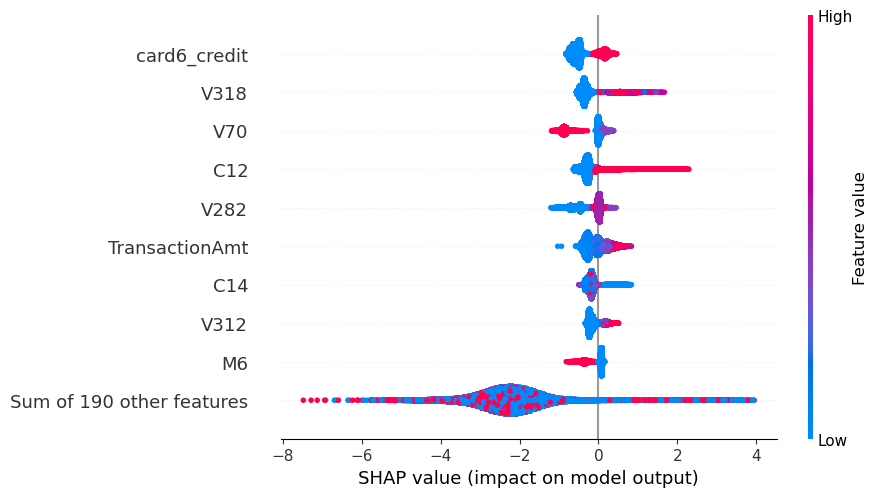

In [19]:
shap.plots.beeswarm(shap_values)

In [20]:
shap.plots.force(shap_values[0])

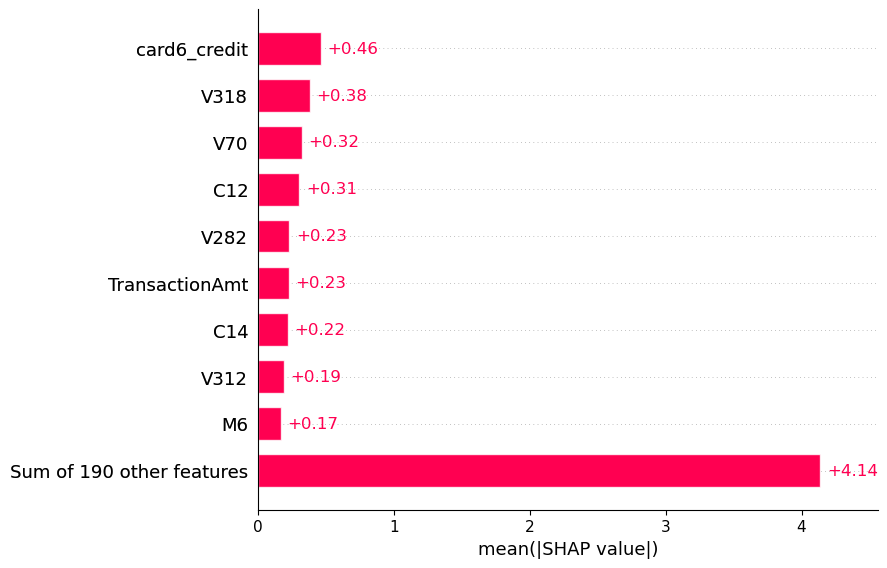

In [21]:
shap.plots.bar(shap_values)

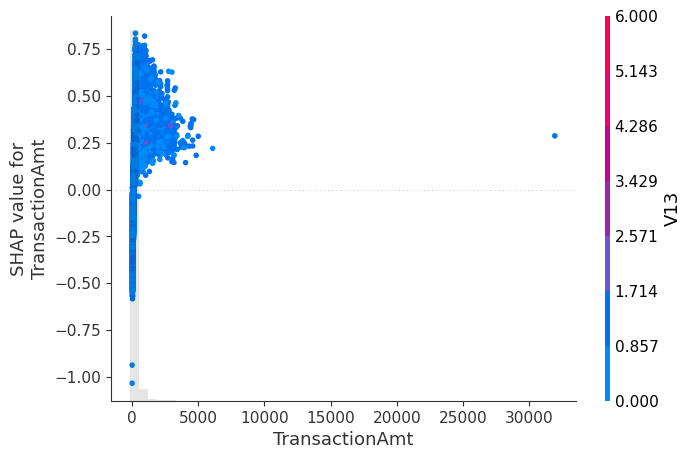

In [22]:
shap.plots.scatter(shap_values[:, "TransactionAmt"], color=shap_values)

#### 5.4.2 Applying LIME to the XGBoost Model

In [23]:
import lime
import lime.lime_tabular

In [24]:
feature_names = X_train.columns.tolist()

In [25]:
X_test.head()

TransactionDT  TransactionAmt  card1   C3     C9  C12    C13    C14  \
203495        4655781           29.54   6107  0.0    4.0  0.0   39.0    4.0   
227933        5407987           57.95   1675  0.0  102.0  0.0  499.0  134.0   
262769        6314603           70.00  16075  0.0    0.0  0.0    1.0    1.0   
388075        9740016           59.00  15063  0.0    1.0  1.0   21.0    3.0   
46351         1108426          100.00  12156  0.0    0.0  0.0    0.0    0.0   

        card2  card3  ...  card4_discover  card4_mastercard  card4_visa  \
203495  467.0  150.0  ...             0.0               0.0         1.0   
227933  174.0  150.0  ...             0.0               0.0         1.0   
262769  514.0  150.0  ...             0.0               1.0         0.0   
388075  514.0  150.0  ...             0.0               0.0         1.0   
46351   555.0  117.0  ...             0.0               1.0         0.0   

        card6_charge card  card6_credit  card6_debit  card6_debit or credit  \
203495                0.0           0.0          1.0                    0.0   
227933                0.0           0.0          1.0                    0.0   
262769                0.0           1.0          0.0                    0.0   
388075                0.0           1.0          0.0                    0.0   
46351                 0.0           1.0          0.0                    0.0   

        M4_M0  M4_M1  M4_M2  
203495    1.0    0.0    0.0  
227933    1.0    0.0    0.0  
262769    1.0    0.0    0.0  
388075    0.0    1.0    0.0  
46351     1.0    0.0    0.0  

[5 rows x 199 columns]

In [26]:
start_time = time.time()

In [27]:
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=feature_names,
    class_names=["non-fraud", "fraud"],
    mode='classification',
    verbose=True,
    random_state = 1
)

In [28]:
i = 0 # Choose an index to explain
sample = X_test.values[i]

In [29]:
lime_exp = lime_explainer.explain_instance(
    data_row=X_test.values[i],
    predict_fn=xgb.predict_proba,
    num_features=10
)

Intercept 1.00381591820701
Prediction_local [0.98932057]
Right: 0.3699655


In [30]:
print(lime_exp.as_list())

[('C14 > 2.13', -0.003106022186874569), ('card6_credit <= 0.00', -0.002481540365712744), ('card4_mastercard <= 0.00', -0.0017751669993543145), ('C12 <= 0.00', -0.0016724831804694532), ('C3 <= 0.00', 0.0016014113178534873), ('TransactionAmt <= 44.13', -0.0014918031115308014), ('V321 > 0.00', -0.0014763535632542157), ('V258 <= 1.34', -0.0014631848209119228), ('V318 <= 0.00', -0.001449241311940903), ('addr2 <= 87.00', -0.0011809608535503333)]


In [31]:
lime_exp.show_in_notebook()

In [32]:
end_time = time.time()
explanation_time = end_time - start_time
print(f"LIME on XGBoost (Explanation Time): {explanation_time:.2f} seconds")

LIME on XGBoost (Explanation Time): 88.74 seconds


#### 5.4.3 Applying Anchors to the XGBoost Model

In [33]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [34]:
# Define the prediction function
predict_fn = lambda x: xgb.predict_proba(x).astype(float)

In [35]:
from alibi.explainers import AnchorTabular

In [36]:
start_time = time.time()

In [37]:
#Set up the Anchor explainer
feature_names = X_train.columns.tolist()
anchor_explainer = AnchorTabular(predict_fn, feature_names=feature_names, categorical_names={})
anchor_explainer.fit(X_train.values, disc_perc=[25, 50, 75])

AnchorTabular(meta={
  'name': 'AnchorTabular',
  'type': ['blackbox'],
  'explanations': ['local'],
  'params': {'seed': None, 'disc_perc': [25, 50, 75]},
  'version': '0.9.6'}
)

In [38]:
#Explain a specific test instance
instance = X_test.iloc[0].values.reshape(1, -1)
anchor_explanation = anchor_explainer.explain(instance,
                                             max_anchor_size=10    # allow up to 10 feature conditions in anchor
                                             )

In [39]:
#Output the results
print("Anchor for this instance:", anchor_explanation.anchor)
print("Precision:", anchor_explanation.precision)
print("Coverage:", anchor_explanation.coverage)

Anchor for this instance: ['V223 > 0.00', 'V283 <= 0.49', 'V318 <= 0.00', 'card6_credit <= 0.00', 'addr1 <= 250.62']
Precision: 0.9534246575342465
Coverage: 0.0541


In [40]:
end_time = time.time()
explanation_time = end_time - start_time
print(f"Anchors on XGBoost (Explanation Time): {explanation_time:.2f} seconds")

Anchors on XGBoost (Explanation Time): 694.33 seconds


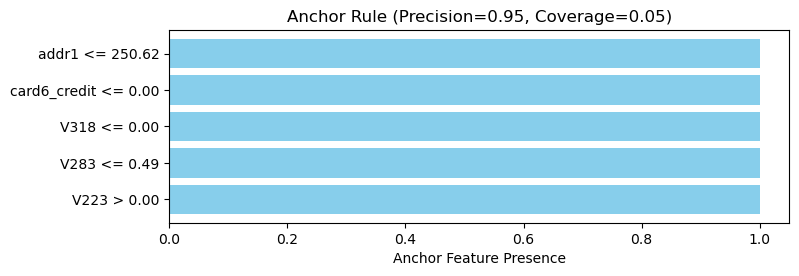

In [41]:
# Extract features and rules from anchor explanation
anchor_rules = anchor_explanation.anchor
precision = anchor_explanation.precision
coverage = anchor_explanation.coverage

# Create a horizontal bar chart
plt.figure(figsize=(8, len(anchor_rules)*0.5))
plt.barh(range(len(anchor_rules)), [1]*len(anchor_rules), color='skyblue')
plt.yticks(range(len(anchor_rules)), anchor_rules)
plt.xlabel('Anchor Feature Presence')
plt.title(f'Anchor Rule (Precision={precision:.2f}, Coverage={coverage:.2f})')
plt.show()

#### 5.4.4 Applying Counterfactual to the XGBoost Model

In [42]:
from sklearn.metrics import pairwise_distances

In [43]:
### Applying Feature Scaling since it is a distance based explanation
sc = StandardScaler()
X_tn_scaled = sc.fit_transform(X_train)
X_tt_scaled = sc.fit_transform(X_test)


# Convert to dataframe
X_train_scaled = pd.DataFrame(X_tn_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_tt_scaled, columns=X_test.columns)

In [44]:
# Show floats with 2 decimal places and avoid scientific notation
pd.set_option('display.float_format', '{:.4f}'.format)

In [45]:
# Assume: X_train, X_test, model
query_instance = X_test_scaled.iloc[0].copy()
query_instance_values = query_instance.values

In [46]:
def predict_label(model, x):
    """
    Predict class for a single instance.
    """
    if hasattr(model, "predict_proba"):
        return model.predict_proba(x.reshape(1, -1))[0,1]  # probability of class 1
    else:
        return model.predict(x.reshape(1, -1))[0]

In [47]:
def distance(x1, x2):
    """Euclidean distance between two instances"""
    return np.linalg.norm(x1 - x2)

In [48]:
def generate_counterfactual(model, x0, total_cfs=3, max_trials=10000, step_size=0.1):
    """
    Generates counterfactuals using random perturbations.
    """
    cf_list = []
    trials = 0
    
    while len(cf_list) < total_cfs and trials < max_trials:
        # Perturb features randomly
        x_cf = x0 + np.random.normal(0, step_size, size=x0.shape)
        
        # Check if prediction flips
        pred_orig = predict_label(model, x0)
        pred_cf = predict_label(model, x_cf)
        
        # For binary classification, flip the label
        if (pred_orig < 0.5 and pred_cf >= 0.5) or (pred_orig >= 0.5 and pred_cf < 0.5):
            cf_list.append(x_cf)
        
        trials += 1
    
    return np.array(cf_list)

In [49]:
start_time = time.time()

In [50]:
counterfactuals = generate_counterfactual(model=xgb, x0=query_instance_values, total_cfs=3)

In [51]:
end_time = time.time()
explanation_time = end_time - start_time
print(f"Counterfactual on XGBoost (Explanation Time): {explanation_time:.2f} seconds")

Counterfactual on XGBoost (Explanation Time): 3.34 seconds


In [52]:
df_cf = pd.DataFrame(counterfactuals, columns=X_test_scaled.columns)
df_compare = pd.concat([query_instance.to_frame().T, df_cf], keys=['Original', 'Counterfactual'])
df_transposed = df_compare.T

In [53]:
df_transposed

Original Counterfactual                
                             0              0       1       2
TransactionDT          -0.5919        -0.7834 -0.6066 -0.7111
TransactionAmt         -0.4256        -0.3891 -0.4668 -0.5194
card1                  -0.7761        -0.7755 -0.6481 -0.8056
C3                     -0.0347         0.1202 -0.0957 -0.1303
C9                     -0.0291         0.0988  0.1985 -0.1095
...                        ...            ...     ...     ...
card6_debit             0.5848         0.6090  0.5571  0.6704
card6_debit or credit  -0.0058        -0.0153 -0.0444 -0.3051
M4_M0                   0.4874         0.4401  0.3429  0.5583
M4_M1                  -0.3136        -0.2685 -0.3567 -0.2470
M4_M2                  -0.3378        -0.3689 -0.3124 -0.2457

[199 rows x 4 columns]